In [2]:
# import pandas as pd
# import numpy as np

# import matplotlib.pyplot as plt 
# #%matplotlib inline 

import seaborn as sns
sns.set(color_codes=True)

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, precision_recall_fscore_support

from sklearn.pipeline import make_pipeline

In [5]:
# All imports required for analysis are below
from __future__ import print_function
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import ipywidgets
from ipywidgets import widgets as wd
import sklearn
# from sklearn import svm
# from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics as mt
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import glob
import os
from IPython.display import Image
# Functions for ROC Graphs
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs, y_test1):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [12]:
os.getcwd() 

'C:\\Users\\danie\\Documents\\GitHub\\Quantifying-The-World\\Final'

In [13]:
#directory = 'C:/Users/N1110/Desktop/QTW/QTW_Final/'
directory = 'C:/Users/danie/Documents/GitHub/Quantifying-The-World/Final'
df_raw = pd.read_csv('final_project.csv')
df_raw.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


In [4]:
df_raw.shape

(160000, 51)

## Data Cleaning

In [5]:
df_raw.dtypes

# x24     object - continents -one hot encoding
# x29     object - month-one hot encoding
# x30     object - day-one hot encoding
# x32     object - can be tranform to float
# x37     object - can be tranform to float

x0     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
x18    float64
x19    float64
x20    float64
x21    float64
x22    float64
x23    float64
x24     object
x25    float64
x26    float64
x27    float64
x28    float64
x29     object
x30     object
x31    float64
x32     object
x33    float64
x34    float64
x35    float64
x36    float64
x37     object
x38    float64
x39    float64
x40    float64
x41    float64
x42    float64
x43    float64
x44    float64
x45    float64
x46    float64
x47    float64
x48    float64
x49    float64
y        int64
dtype: object

In [14]:
#data cleaning
df_raw['x32'] = df_raw['x32'].str.replace('%', '')
df_raw['x32'] = df_raw['x32'].astype(float)


In [15]:
df_raw.x32.head()

0    0.00
1   -0.02
2   -0.01
3    0.01
4    0.01
Name: x32, dtype: float64

In [16]:
df_raw['x37'] = df_raw['x37'].str.replace('$', '')
df_raw['x37'] = df_raw['x37'].astype(float)
df_raw.x37.head()

0    1313.96
1    1962.78
2     430.47
3   -2366.29
4    -620.66
Name: x37, dtype: float64

In [17]:
df_raw.describe()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000,...,159960.000000,159974.000000,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000,160000.000000
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549,0.013582,-1.670670,-7.692795,-0.030540,0.005462,...,6.701076,-1.833820,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224,0.401231
std,0.371137,6.340632,13.273480,8.065032,6.382293,7.670076,19.298665,30.542264,8.901185,6.355040,...,18.680196,5.110705,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738,0.490149
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659,...,-82.167224,-27.933750,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191,0.000000
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619,...,-5.804080,-5.162869,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753,0.000000
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857,0.014118,-1.948594,-6.956789,-0.016840,0.006045,...,6.840110,-1.923754,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410,0.000000
75%,0.248532,4.284220,7.871676,5.445179,4.306660,5.190749,11.446931,12.217071,5.972349,4.305734,...,19.266367,1.453507,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072,1.000000
max,1.600849,27.988178,63.545653,38.906025,26.247812,35.550110,92.390605,149.150634,39.049831,27.377842,...,100.050432,22.668041,6.680922,19.069759,1.669205,150.859415,20.836854,8.226552,66.877604,1.000000


In [18]:
# check missing values
df_raw_NullCols = df_raw.isnull().sum()
df_raw_NullCols = df_raw_NullCols[df_raw_NullCols > 0]

df_raw_NullCols = pd.DataFrame({'n Missing' : df_raw_NullCols,
                                  '% Missing' : ((df_raw_NullCols / df_raw.shape[0])*100).round(2)})


df_raw_NullCols = df_raw_NullCols.sort_values('n Missing')

cm = sns.light_palette("red", as_cmap=True)
df_raw_NullCols.style.background_gradient(cmap=cm)

,n Missing,% Missing
x8,21,0.010000
x25,22,0.010000
x39,23,0.010000
x37,23,0.010000
x1,25,0.020000
x0,26,0.020000
x42,26,0.020000
x4,26,0.020000
x6,26,0.020000
x16,26,0.020000


In [11]:
# x34, x33, x10, x23 have 3% missing values, others have below 2%. 
# we should still have enough data after drop a small percentage of NA

In [19]:
df_raw.dropna(inplace = True)
df_raw.shape

(158392, 51)

In [20]:
# x29 only keep 3 characters
df_raw['x29'].replace(to_replace='January', value='Jan',inplace=True)
df_raw['x29'].replace(to_replace='sept.', value='Sep',inplace=True)
df_raw['x29'].replace(to_replace='Dev', value='Dec',inplace=True)
df_raw['x29'].replace(to_replace='July', value='Jul',inplace=True)
# x32 change to float
if(df_raw['x32'].dtypes!='float64'):
    df_raw['x32'] =df_raw['x32'].str[:-1].astype(float)
# x37 change to float
if(df_raw['x37'].dtypes!='float64'):
    df_raw['x37'] = df_raw['x37'].str.replace('$', '')
    df_raw['x37'] =df_raw['x37'].str[:-1].astype(float)

In [21]:
#check all obj attributes
for col in list(df_raw.select_dtypes(include=['object']).columns):
    print(col)
    print('------------------------------------------------')
    print(df_raw[col].value_counts().sort_values(),'\n')

x24
------------------------------------------------
america      4418
euorpe      16378
asia       137596
Name: x24, dtype: int64 

x29
------------------------------------------------
Jan        9
Dec       23
Feb      139
Nov      331
Mar     1221
Oct     2385
Apr     6699
Sep    10740
May    21708
Aug    29115
Jun    40900
Jul    45122
Name: x29, dtype: int64 

x30
------------------------------------------------
monday          484
friday          556
tuesday       27690
thurday       29164
wednesday    100498
Name: x30, dtype: int64 



In [22]:
df_raw.dtypes

x0     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
x18    float64
x19    float64
x20    float64
x21    float64
x22    float64
x23    float64
x24     object
x25    float64
x26    float64
x27    float64
x28    float64
x29     object
x30     object
x31    float64
x32    float64
x33    float64
x34    float64
x35    float64
x36    float64
x37    float64
x38    float64
x39    float64
x40    float64
x41    float64
x42    float64
x43    float64
x44    float64
x45    float64
x46    float64
x47    float64
x48    float64
x49    float64
y        int64
dtype: object

In [23]:
#Isolate remaining categorical variables
begColumnCt = len(df_raw.columns)
sD_nominal = df_raw.loc[:, (df_raw.dtypes == object)]

#one hot encode categorical variables
df_raw = pd.get_dummies(data=df_raw, 
                       columns=sD_nominal.columns, drop_first=True)

#Determine change in column count
endColumnCt = len(df_raw.columns)
columnsAdded = endColumnCt - begColumnCt

df_raw.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x29_Jun,x29_Mar,x29_May,x29_Nov,x29_Oct,x29_Sep,x30_monday,x30_thurday,x30_tuesday,x30_wednesday
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,0,0,0,0,0,0,0,0,1,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,0,0,0,0,0,0,0,0,0,1
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,0,0,0,0,0,0,0,0,0,1
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,0,0,0,0,0,0,0,0,0,1
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,0,0,0,0,0,0,0,0,1,0


In [24]:
df_raw.dtypes

x0               float64
x1               float64
x2               float64
x3               float64
x4               float64
                  ...   
x29_Sep            uint8
x30_monday         uint8
x30_thurday        uint8
x30_tuesday        uint8
x30_wednesday      uint8
Length: 65, dtype: object

Class 0: 94846
Class 1: 63546


<Figure size 576x360 with 0 Axes>

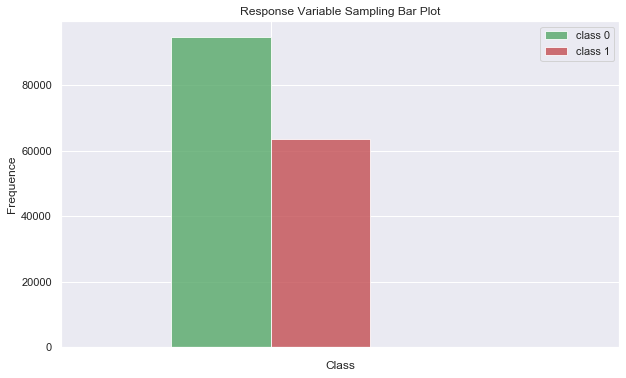

In [25]:
# check distribution of y 

plt.figure(figsize=(8,5))
target_count = df_raw.y.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

# Plot bar graph

# Data to plot
n_groups = 1
class0=df_raw.y.value_counts()[0]
class1=df_raw.y.value_counts()[1]
 
# Create plot
index = np.arange(n_groups)
bar_width = 0.5
opacity = 0.8
plt.figure(figsize=(10,6))
plt.bar(index, class0, bar_width,
                 alpha=opacity,
                 color='g',
                 label='class 0')
 
plt.bar(index + bar_width, class1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='class 1')
 
plt.xlabel('Class')
plt.ylabel('Frequence')
plt.title('Response Variable Sampling Bar Plot')
plt.xlim(-0.8, 2)
plt.xticks(index + bar_width/2, (''))
plt.legend()
 
plt.show()

In [26]:
# y is not too imbalanced, so would not be a concern

## Feature Selection

In [27]:
# check corr of all attributes after transformation
corr_matrix = df_raw.corr().abs()
# Select upper triangle of correlation matrix
correlated = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.5
dropme_correlated = [column for column in correlated.columns if any(correlated[column] > 0.75)]
dropme_correlated

['x6', 'x41', 'x24_euorpe']

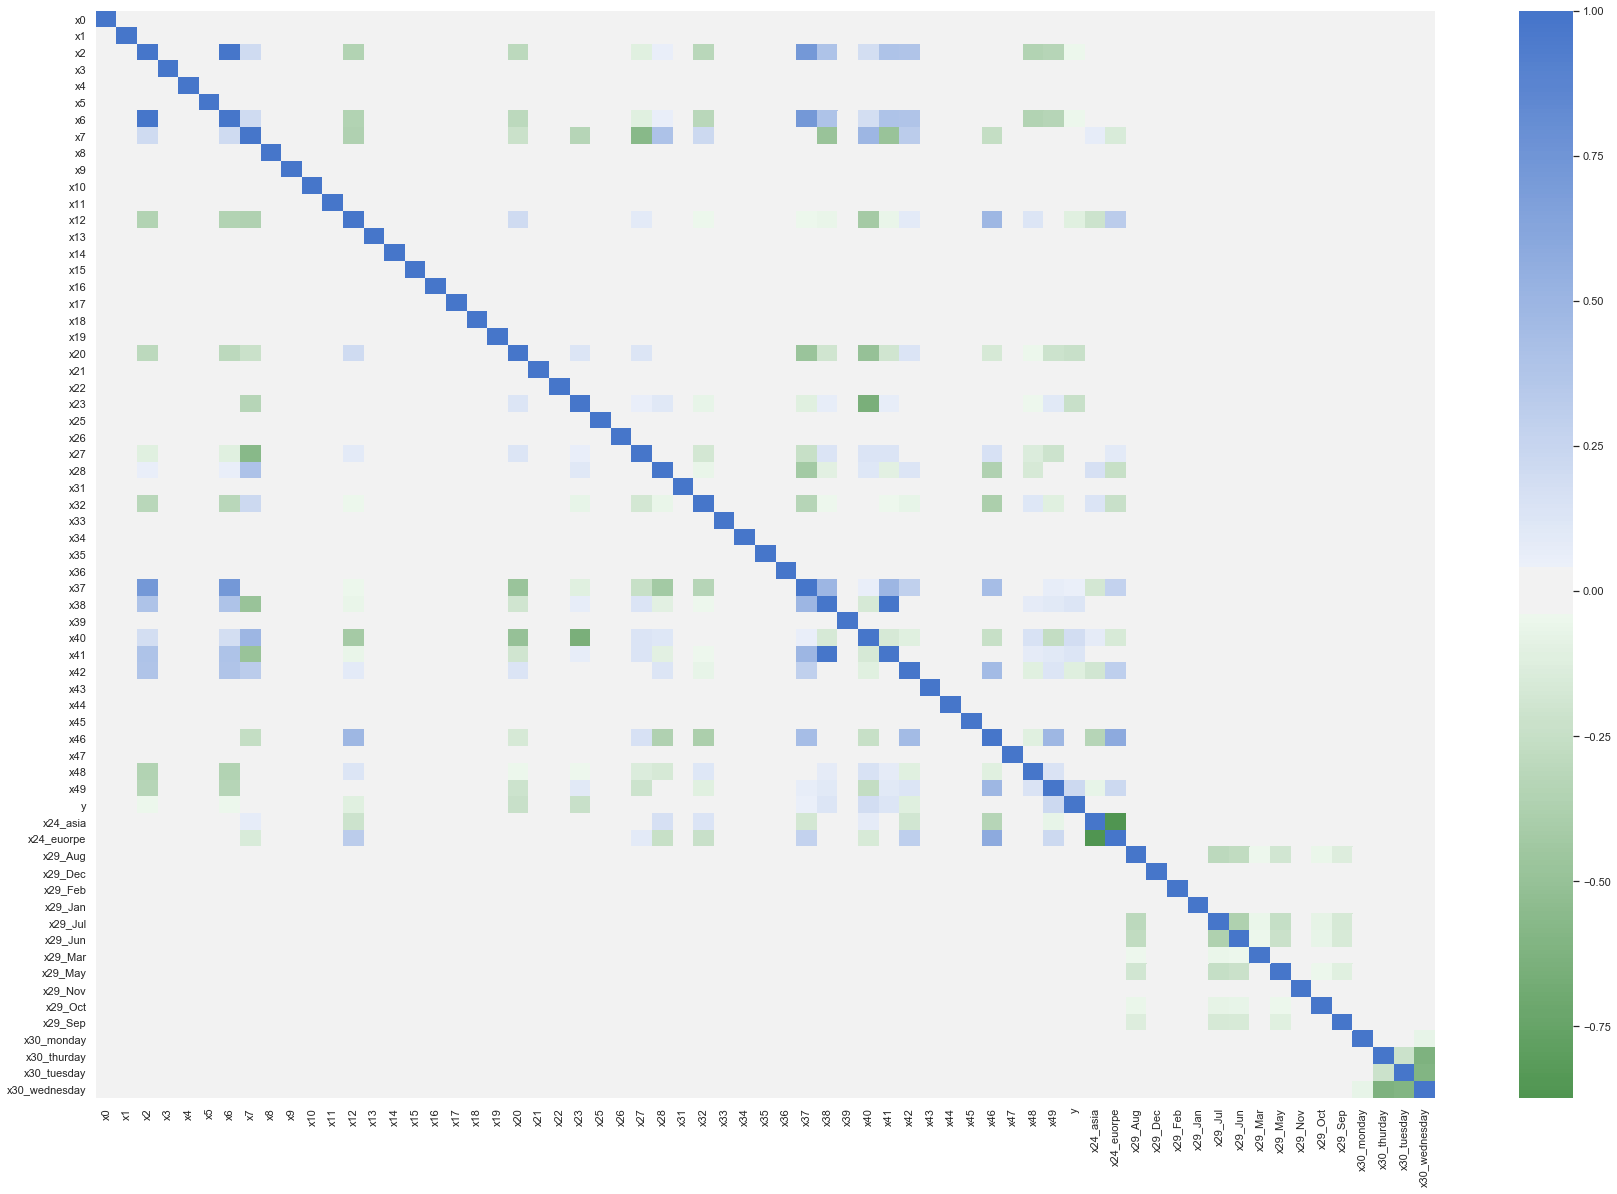

In [28]:
danpallet= sns.diverging_palette(128, 255, l=50, n=7, center="light",as_cmap=True)
plt.figure(figsize=(30,20))
c= df_raw.corr()
sns.heatmap(c,annot=False, center=0, cmap=danpallet)

In [22]:
# x20,23,40,49 seem to correlate to y relatively higher. so these could be important features.
# many x are correlated. 
# due to the multicolinearity in the dataset, we choose RF, XGB which does not have assumptions on multicolinearity like logistic reg

In [29]:
df_imputed=df_raw.sample(frac=0.2) #subsample 20% of data to try

In [30]:
df_imputed.to_csv("df_imputed.csv") #save 20% one hot encoded  data 
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31678 entries, 30834 to 141863
Data columns (total 65 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x0             31678 non-null  float64
 1   x1             31678 non-null  float64
 2   x2             31678 non-null  float64
 3   x3             31678 non-null  float64
 4   x4             31678 non-null  float64
 5   x5             31678 non-null  float64
 6   x6             31678 non-null  float64
 7   x7             31678 non-null  float64
 8   x8             31678 non-null  float64
 9   x9             31678 non-null  float64
 10  x10            31678 non-null  float64
 11  x11            31678 non-null  float64
 12  x12            31678 non-null  float64
 13  x13            31678 non-null  float64
 14  x14            31678 non-null  float64
 15  x15            31678 non-null  float64
 16  x16            31678 non-null  float64
 17  x17            31678 non-null  float64
 18  x

## Train, test split

In [31]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'y' in df_imputed:
    y = df_imputed['y'].values # get the labels we want
    del df_imputed['y'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [32]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [33]:
#RF baseline model
#

#run for 1-2 mins
NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
from sklearn.ensemble import RandomForestClassifier
rf_clfBASE = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clfBASE.fit(X_train_scaled,y_train)

preds = rf_clfBASE.predict(X_test_scaled)
print('Random Forest BASE - roc_auc_score: ', roc_auc_score(y_test, preds)) 
# Random Forest BASE - roc_auc_score:  0.8895059143941451

Random Forest BASE - roc_auc_score:  0.8799472903969692


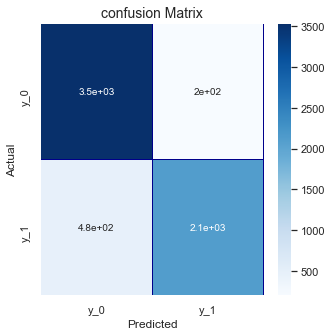

In [34]:
#Confusion Matrix # need to run for BASE parameter RF
cm = pd.crosstab(y_test, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm, xticklabels = ['y_0', 'y_1'], yticklabels = ['y_0', 'y_1'], 
            annot = True, ax = ax1,
            linewidths = .2, linecolor = 'Darkblue', cmap ='Blues')
plt.title('confusion Matrix', fontsize = 14)
plt.show()

## RandomizedSearchCV

In [35]:
#To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [36]:
# run for 20 min
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100? different combinations, and (use all available cores-n job =-1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=False, random_state=2000, n_jobs = 4)

# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [37]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [38]:
# alert when above done
import winsound
winsound.Beep(500,1000)

In [39]:
#run best parameter RF
NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', min_samples_split=10,min_samples_leaf=1,
                                max_features='sqrt', max_depth=50, bootstrap = False,
                                n_estimators = 1800, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 

# Random Forest - roc_auc_score:  0.9043234045022768
# RF auc improve after parameters tuning

# second run Random Forest - roc_auc_score:  0.8993454200337757

Random Forest - roc_auc_score:  0.8950980069181353


In [40]:
type(preds)

numpy.ndarray

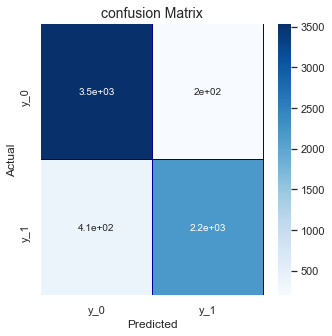

In [41]:
#Confusion Matrix # need to run for best parameter RF
cm = pd.crosstab(y_test, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm, xticklabels = ['y_0', 'y_1'], yticklabels = ['y_0', 'y_1'], 
            annot = True, ax = ax1,
            linewidths = .2, linecolor = 'Darkblue', cmap ='Blues')
plt.title('confusion Matrix', fontsize = 14)
plt.show()

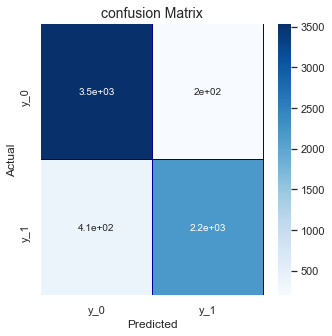

In [42]:
#result form 1st run # Random Forest - roc_auc_score:  0.9043234045022768
#Confusion Matrix # need to run for best parameter RF
cm = pd.crosstab(y_test, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm, xticklabels = ['y_0', 'y_1'], yticklabels = ['y_0', 'y_1'], 
            annot = True, ax = ax1,
            linewidths = .2, linecolor = 'Darkblue', cmap ='Blues')
plt.title('confusion Matrix', fontsize = 14)
plt.show()

In [43]:
total_accuracy_rf = mt.accuracy_score(y_test, preds)
total_precision_rf = precision_score(y_test, preds)
classification_rpt_rf = classification_report(y_test, preds)
print ("RandomForest accuracy with corresponding parameter settings")
print('RandomForest classifier accuracy with optimal parameters is: %.3f'%(total_accuracy_rf))
print('RandomForest classifier precision with optimal parameters is: %.3f'%(total_precision_rf))
print('RandomForest classifier classsification report with optimal parameters is: \n',(classification_rpt_rf))

RandomForest accuracy with corresponding parameter settings
RandomForest classifier accuracy with optimal parameters is: 0.904
RandomForest classifier precision with optimal parameters is: 0.917
RandomForest classifier classsification report with optimal parameters is: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      3736
           1       0.92      0.84      0.88      2600

    accuracy                           0.90      6336
   macro avg       0.91      0.90      0.90      6336
weighted avg       0.91      0.90      0.90      6336



[0.94673448 0.84346154]


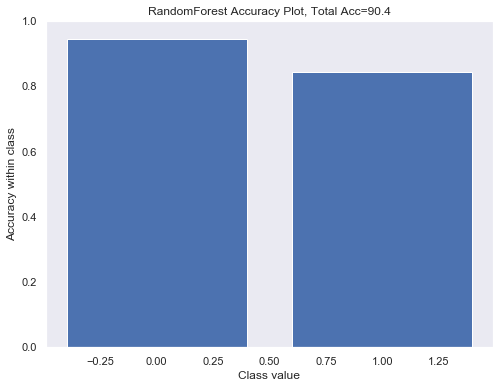

In [44]:
# get classification accuracy
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)
# draw classification accuracy confusion Matrix
def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.figure(figsize=(8,6))
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.savefig(title)
    plt.show()
    
print(per_class_accuracy(y_test, preds))
plot_class_acc(y_test, preds,title="RandomForest Accuracy Plot")

In [45]:
rf_clf.feature_importances_

array([7.17191090e-03, 7.05107906e-03, 2.90384432e-02, 7.14723898e-03,
       6.96926586e-03, 6.97303609e-03, 2.94513026e-02, 4.09906009e-02,
       7.23843529e-03, 7.14953979e-03, 6.89136364e-03, 7.15217751e-03,
       4.96121206e-02, 7.21548191e-03, 6.99516597e-03, 7.22441894e-03,
       7.28493476e-03, 7.05119408e-03, 6.96839133e-03, 7.11726070e-03,
       6.60387405e-02, 7.05187945e-03, 7.08997625e-03, 7.62505275e-02,
       7.06479522e-03, 7.36437224e-03, 4.53833367e-02, 4.54417445e-02,
       7.07052142e-03, 2.37471586e-02, 7.43468628e-03, 7.11158286e-03,
       7.19737940e-03, 6.72980914e-03, 4.43656237e-02, 3.67810986e-02,
       7.04305633e-03, 4.55725401e-02, 3.65252643e-02, 4.91187259e-02,
       7.18512784e-03, 7.39195352e-03, 7.33775973e-03, 3.56387467e-02,
       7.13191248e-03, 5.96946293e-02, 6.05963984e-02, 3.62670653e-03,
       3.17628936e-03, 5.59067752e-04, 3.18871761e-05, 1.64433253e-05,
       0.00000000e+00, 5.36378279e-04, 5.73518137e-04, 1.98738889e-04,
      

Text(0.5, 1.0, 'feature_importances')

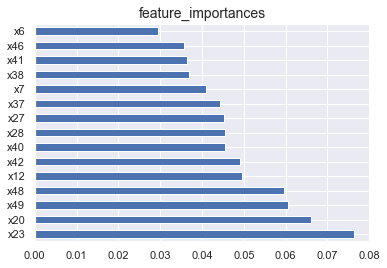

In [46]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=df_imputed.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('feature_importances', fontsize = 14)

## RF feature_importances
#### During feature selection, in the correlation matrix heatmap, we noticed x20,23,40,49 seem to correlate to y relatively higher. so these could be important features. #### From the above plot of RF model feature_importances, we can see x23,20,49 are most important features. So our guess is correct!!!!

In [36]:
## RF training curves

In [37]:
final_model=rf_clf
#rf_clf to replace final_model

In [ ]:
# # run for too long aborted
# from sklearn.model_selection import GridSearchCV, cross_val_score
# # Grid with only the number of trees changed
# tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 1801, 30)]}

# # Create the grid search model and fit to the training data
# tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = False, n_jobs=4, cv = 3,
#                                 scoring = 'neg_mean_absolute_error')
# tree_grid_search.fit(X_train_scaled,y_train);

In [47]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    #plt.ylim(ymin = -2, ymax = 1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    #plt.ylim(ymin = 0.0, ymax = 200.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)
    plot_results(tree_grid_search)

In [48]:
#Grid with only the 'max_depth'
tree_grid = {'max_depth': [ 20 , 30, 40, 50, 60]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = False, n_jobs=4, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train_scaled,y_train);

def plot_results(model, param = 'max_depth', name = 'max_depth'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    #plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
   # plt.ylim(ymin = 0.0, ymax = 200.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)
    
    plot_results(tree_grid_search)

NameError: name 'final_model' is not defined

In [ ]:
import winsound
winsound.Beep(500,1000)

## XGB

In [49]:
#in case df messed up
#dropped y in previous code, so need to reimport data

df_imputed = pd.read_csv("df_imputedUpdated2.csv")  #start with window
df_imputed.head(5)

,Unnamed: 0,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x29_Jun,x29_Mar,x29_May,x29_Nov,x29_Oct,x29_Sep,x30_monday,x30_thurday,x30_tuesday,x30_wednesday
0,30834,-0.112671,-8.203438,1.077702,7.489478,11.461323,-5.309865,1.566898,-51.615013,-1.820075,...,1,0,0,0,0,0,0,0,1,0
1,117692,0.326004,4.291305,16.988494,8.165191,-4.040805,-3.833060,24.699993,-19.586295,0.247806,...,0,0,0,0,0,0,0,0,0,1
2,1709,-0.152247,-6.638029,8.946073,-16.093238,-6.263222,-0.391369,13.006918,-27.674188,-1.950963,...,1,0,0,0,0,0,0,0,0,1
3,69461,0.282493,10.181250,2.407180,-4.653488,1.070715,10.731340,3.499859,8.847177,6.515423,...,0,0,0,0,0,0,0,0,0,1
4,30022,0.412915,-5.840544,-32.653326,-2.518840,11.641272,-12.824416,-47.475483,-56.076918,-6.774558,...,1,0,0,0,0,0,0,0,0,1


In [50]:
df_imputed.shape

(31678, 66)

In [51]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'y' in df_imputed:
    y = df_imputed['y'].values # get the labels we want
    del df_imputed['y'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [52]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [53]:
#baseline
import xgboost as xgb


#XGBOOST parameters 1
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50
RANDOM_STATE = 2000

#XGBOOST transform data into DMatrix format for modeling
dtrain = xgb.DMatrix(X_train_scaled, y_train)
dvalid = xgb.DMatrix(X_test_scaled, y_test)
type(dtrain)


# XGBoost Parameters 2
params = {}
params['objective'] = 'binary:logistic'
#params['objective'] = 'multi:softmax'
#params['objective'] = 'reg:linear'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]



In [54]:
xgb_clf = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)

[0]	train-auc:0.70608	valid-auc:0.68956
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.80242	valid-auc:0.78449
[100]	train-auc:0.83927	valid-auc:0.81967
[150]	train-auc:0.85938	valid-auc:0.83921
[200]	train-auc:0.87199	valid-auc:0.85212
[250]	train-auc:0.88010	valid-auc:0.86039
[300]	train-auc:0.88790	valid-auc:0.86842
[350]	train-auc:0.89468	valid-auc:0.87545
[400]	train-auc:0.89950	valid-auc:0.87983
[450]	train-auc:0.90389	valid-auc:0.88458
[500]	train-auc:0.90761	valid-auc:0.88836
[550]	train-auc:0.91093	valid-auc:0.89156
[600]	train-auc:0.91373	valid-auc:0.89421
[650]	train-auc:0.91635	valid-auc:0.89692
[700]	train-auc:0.91941	valid-auc:0.90012
[750]	train-auc:0.92210	valid-auc:0.90312
[800]	train-auc:0.92419	valid-auc:0.90501
[850]	train-auc:0.92612	valid-auc:0.90679
[900]	train-auc:0.92859	valid-auc:0.90900
[950]	train-auc:0.93073	valid-auc:0.91091
[999]	train-auc:0.93

In [55]:
preds = xgb_clf.predict(dvalid)
print('XGBoost - roc_auc_score: ', roc_auc_score(y_test, preds)) 

# XGBoost - roc_auc_score:  0.9207827685624094
# XGBoost - roc_auc_score:  0.9128279684449344

XGBoost - roc_auc_score:  0.9116026258250879


In [56]:
type(preds)

numpy.ndarray

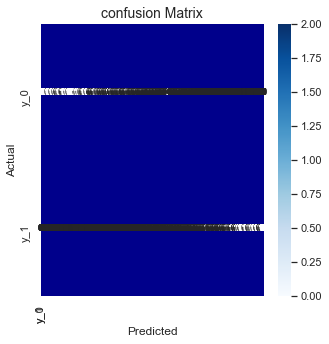

In [57]:
#Confusion Matrix for best XGB
cm = pd.crosstab(y_test, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm, xticklabels = ['y_0', 'y_1'], yticklabels = ['y_0', 'y_1'], 
            annot = True, ax = ax1,
            linewidths = .2, linecolor = 'Darkblue', cmap ='Blues')
plt.title('confusion Matrix', fontsize = 14)
plt.show()

In [58]:
total_accuracy_xgb = mt.accuracy_score(y_test, preds)
total_precision_xgb = precision_score(y_test, preds)
classification_rpt_xgb = classification_report(y_test, preds)
print ("XGB accuracy with corresponding parameter settings")
print('XGB classifier accuracy with optimal parameters is: %.3f'%(total_accuracy_xgb))
print('XGB classifier precision with optimal parameters is: %.3f'%(total_precision_xgb))
print('XGB classifier classsification report with optimal parameters is: \n',(classification_rpt_xgb))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [44]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [45]:
# A parameter grid for XGBoost
#at least include the parameters already included in the baseline model for chance to find one better than base model.
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.9],
        'max_depth': [2, 5]
        }

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime

folds = 3
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

xgb_algo = xgb.XGBClassifier()
random_search = RandomizedSearchCV(xgb_algo,
                                   param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=50, random_state=2000)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train_scaled, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done   3 out of   9 | elapsed:   27.5s remaining:   55.0s
[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:   27.5s remaining:   34.4s
[Parallel(n_jobs=4)]: Done   5 out of   9 | elapsed:   34.2s remaining:   27.4s
[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed:   40.0s remaining:   20.0s
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:   41.2s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:   46.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:   46.0s finished

 Time taken: 0 hours 0 minutes and 53.54 seconds.


In [48]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

 Best normalized gini score for 3-fold search with 3 parameter combinations:
0.9013276226602549

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.6}


In [49]:
# 0.9013276226602549

In [56]:
# start_time = timer(None)

xgb_best = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing= None, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

xgb_best.fit(X_train_scaled, y_train)

# timer(start_time)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

In [57]:
# timer the testing time
start_time = timer(None)
preds = xgb_best.predict(X_test_scaled)
timer(start_time)
print('XGB - roc_auc_score: ', roc_auc_score(y_test, preds)) 


 Time taken: 0 hours 0 minutes and 0.1 seconds.
XGB - roc_auc_score:  0.8899928907054784


In [ ]:
# parameter searching did not improve the roc auc because used very limited parameter grid.

In [ ]:
# calculate cost

# cost function:
#  Total Cost = 10 * Count of FP + 500 * Count of FN